# Processes all photos down to a size not exceeding 512 pixels in either width or height

In [1]:
# Rescale images
from PIL import Image
import glob, os

size = 512, 512

foldername = "fuzhou"
count = 0
for infile in glob.glob("{}/*".format(foldername)):
    im = Image.open(infile)
    im = im.resize(size, Image.ANTIALIAS)
    im.save("rescaled_{}/".format(foldername) + 
            "{}.JPEG".format(count), "JPEG")
    count += 1

In [2]:
# Load data
from PIL import Image
import glob, os
import numpy as np

def image_to_array(im):
    """
    Reference: https://stackoverflow.com/questions/13550376
    /pil-image-to-array-numpy-array-to-array-python
    """      
    im_arr = np.fromstring(im.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((im.size[1], im.size[0], 3)) 
    return im_arr

data = []
for infile in glob.glob("rescaled_fuzhou/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append(pixels)

In [51]:
print "Number of images =", len(data),"; Shape = ", data[0].shape

Number of images = 94 ; Shape =  (512, 512, 3)


# Using principal components analysis project your images down to a 2 dimensional representation

Note that before applying PCA, I normalize the data so they have zero mean and unit variance.

In [9]:
# Flatten the images to 1D array
X = [_.ravel() for _ in data]

In [11]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [16]:
# Fit PCA with two components
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)
pca_2d.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Visually inspect the 2D locations of each photo in the new space

In [17]:
# Project the images into the 2D coordinate space
X_pca_2d = pca_2d.transform(X_scaled)

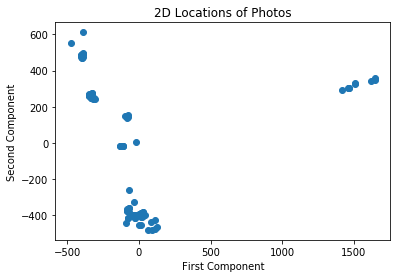

In [22]:
# Make scatter plot
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1])
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.title("2D Locations of Photos")
plt.show()

Since I took most of the photos during the day (late afternoon) when the sun was still out and only a few photos after sunset, I suspect that the data points on the right side are those taken at night.

# Show the reconstruction from each low-dimensional representation

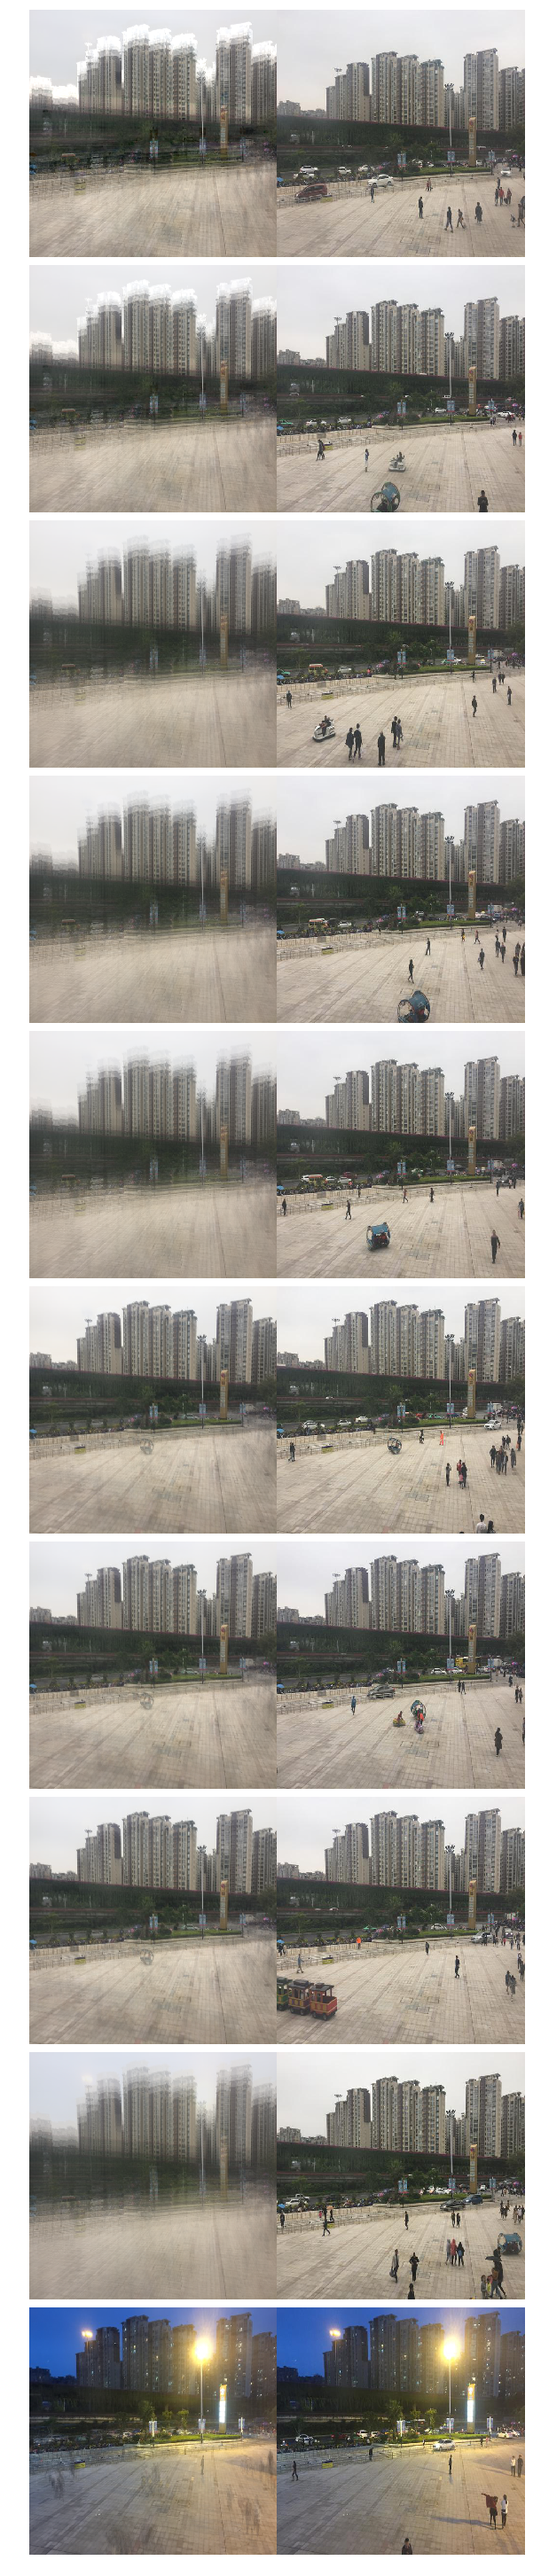

In [54]:
import numpy as np
selected = [0, 3, 15, 21, 26, 30, 53, 65, 80, 93]
plt.figure(figsize=(10,40))
vfunc = np.vectorize(lambda x: max(min(255,x), 0))
for i in range(10):
    c = pca_2d.components_
    r = selected.pop(0)
    max_ = X_pca_2d.max(axis=0)
    min_ = X_pca_2d.min(axis=0)
    arr = X_pca_2d[r]
    arr = pca_2d.inverse_transform(arr)
    arr = scaler.inverse_transform(arr)
    arr = vfunc(arr)
    # Reconstructed
    arr.shape = (512,512,3)
    im = Image.fromarray(np.uint8(arr))
    plt.subplot(10, 2, i*2+1)
    plt.imshow(im)
    plt.axis("off")
    # Original
    arr = data[r]
    im = Image.fromarray(np.uint8(arr))
    plt.subplot(10,2, i*2+2)
    plt.imshow(im)
    plt.axis("off")
plt.subplots_adjust(top=1, bottom=0, wspace=0, hspace=0)
plt.show()

The 1st-9th photos were taken during the day, and the reconstructions omit the details of the pictures such as pedastrians, cars and children's rides. Besides, we can also see that some reconstructions are "blurred" whereas others are sharp. I think this is because my photos were taken at slightly different angles (note that the margins between the top of the buildings and the upper border of the pictures vary slightly). Therefore, the "blurred" reconstructions seem to be an attempt to find the middle points between the narrowest and the widest margin. However, since the model is linear in each pixel, the middle point would create a picture that looks like an overlap of the two extremes.

The last photo was taken at night, and the reconstruction also omits the pedestrians (although we can still see some shadows).

# Finally pick a point that is far away from any known location and plot its reconstruction

Let's look at our scatterplot again.

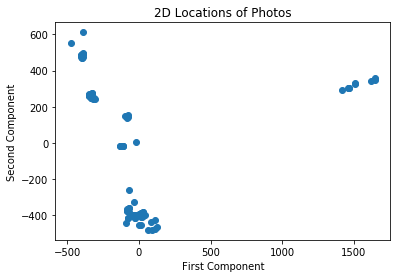

In [50]:
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1])
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.title("2D Locations of Photos")
plt.show()

First, it'll be interesting to look at the extreme points, with x coordinates at -500 and 1500 and y coordinates at -400 and 600.

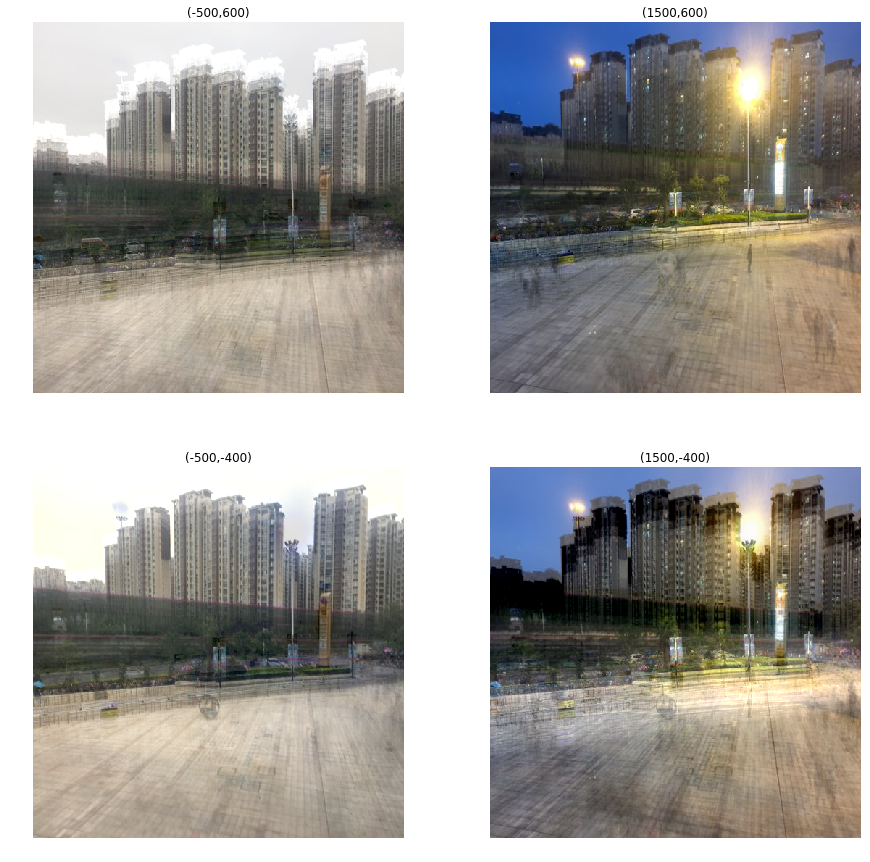

In [39]:
# Extreme points photos
import numpy as np
madeup = [[-500, 600], [1500,600],[-500,-400],[1500,-400]]
plt.figure(figsize=(15,15))
vfunc = np.vectorize(lambda x: max(min(255,x), 0))
for i, coord in enumerate(madeup):
    c = pca_2d.components_
    max_ = X_pca_2d.max(axis=0)
    min_ = X_pca_2d.min(axis=0)
    arr = [_ for _ in coord]
    arr = pca_2d.inverse_transform(arr)
    arr = scaler.inverse_transform(arr)
    arr = vfunc(arr)
    arr.shape = (512,512,3)
    im = Image.fromarray(np.uint8(arr))
    plt.subplot(2,2, i+1)
    plt.imshow(im)
    plt.title("({},{})".format(*coord))
    plt.axis("off")
plt.show()

This seems to verify my earlier hypothesis. The left column shows the day scene and the right column shows the night scene. That corresponds to the first component of PCA. As for the second component, if we compare the top and bottom left pictures, we can see that the top one has wider margin (we can even see the trace of the "taller" buildings) and the bottom one has narrower margin. The bottom one looks like a better recreation of the reality because most of the data are concentrated in that region and therefore is "prioritized". On the contrary, if we look at the right column, the narrow-wide margin features are not presented very well. Since we have fewer data for the night, the quality for this region is "sacrificed'

Below are plots with finer intervals. It is arranged so that the position of each photo corresponds to their relative position on the scatterplot. Again we see that the better quality pictures are located in areas with more data. The pictures that are far away from any known data have poor quality (in the sense of being less similar to our reality).

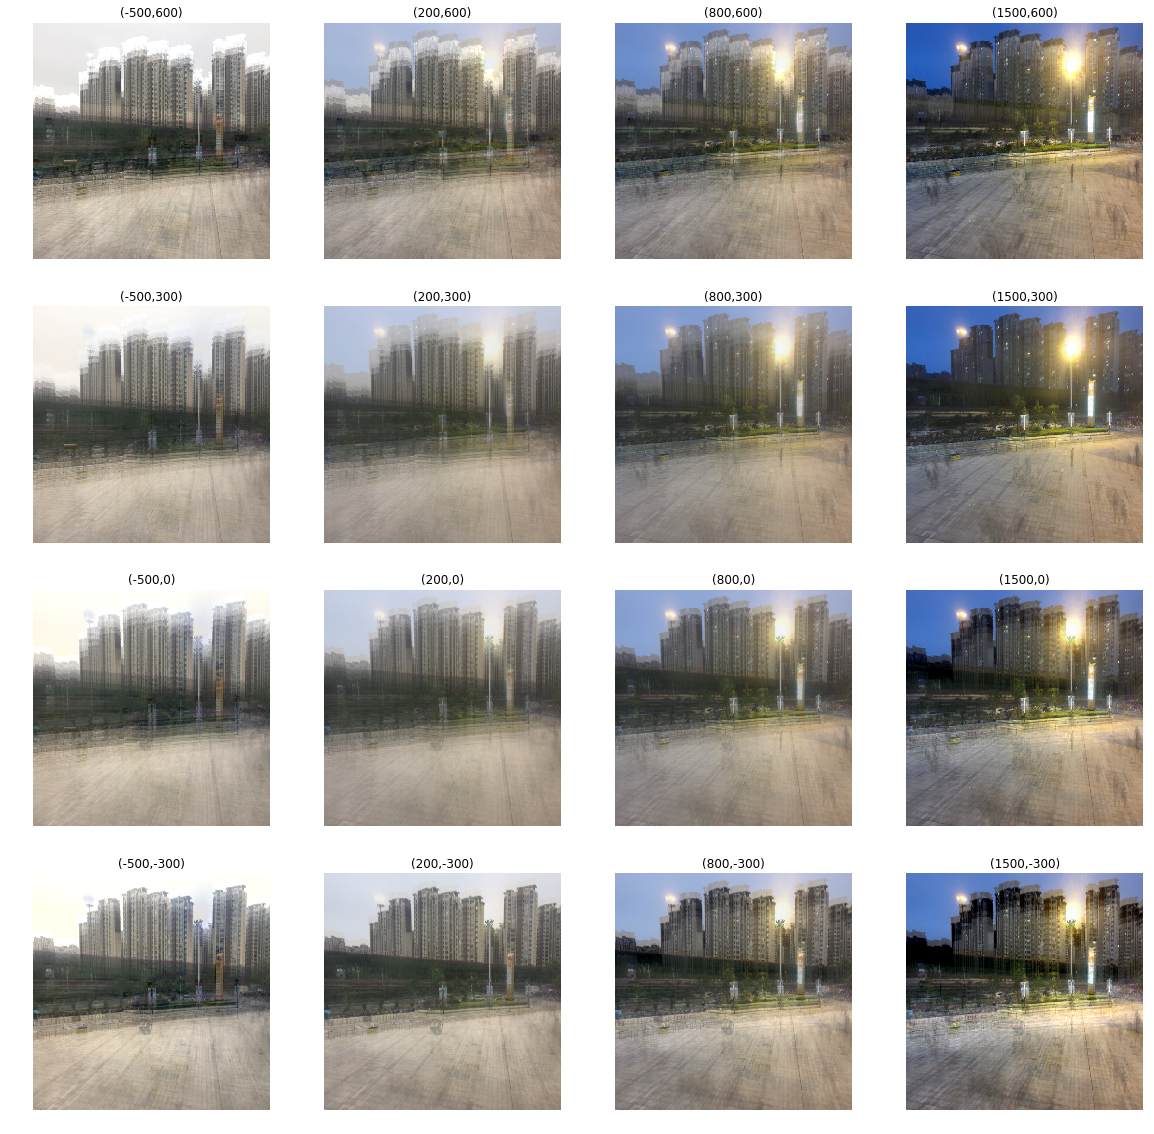

In [49]:
import numpy as np
madeup = [[-500, 600], [200, 600],[800,600],[1500,600],
          [-500, 300], [200, 300],[800,300],[1500,300],
          [-500, 0], [200, 0],[800,0],[1500,0],
          [-500, -300], [200, -300],[800,-300],[1500,-300]]
plt.figure(figsize=(20,20))
vfunc = np.vectorize(lambda x: max(min(255,x), 0))
for i, coord in enumerate(madeup):
    c = pca_2d.components_
    max_ = X_pca_2d.max(axis=0)
    min_ = X_pca_2d.min(axis=0)
    arr = [_ for _ in coord]
    arr = pca_2d.inverse_transform(arr)
    arr = scaler.inverse_transform(arr)
    arr = vfunc(arr)
    arr.shape = (512,512,3)
    im = Image.fromarray(np.uint8(arr))
    plt.subplot(4, 4, i+1)
    plt.imshow(im)
    plt.title("({},{})".format(*coord))
    plt.axis("off")
plt.show()